# Implementation of FFT and IFFT

### Libraries

In [2]:
import cmath
import numpy as np
from math import log, ceil
import pylab as plt
import cv2

### Utils

In [3]:
def omega(p, q):
    ''' The omega term in DFT and IDFT formulas'''
    return cmath.exp((2.0 * cmath.pi * 1j * q) / p)

def pad(lst):
    '''padding the list to next nearest power of 2 as FFT implemented is radix 2'''
    k = 0
    while 2**k < len(lst):
        k += 1
    return np.concatenate((lst, ([0] * (2 ** k - len(lst)))))

def pad2(x):
    m, n = np.shape(x)
    M, N = 2 ** int(ceil(log(m, 2))), 2 ** int(ceil(log(n, 2)))
    F = np.zeros((M,N), dtype = x.dtype)
    F[0:m, 0:n] = x
    return F, m, n

## FFT

In [4]:
## FFT - 1D
def fft(x):
    ''' FFT of 1-d signals
    usage : X = fft(x)
    where input x = list containing sequences of a discrete time signals
    and output X = dft of x '''

    n = len(x)
    if n == 1:
        return x
    Feven, Fodd = fft(x[0::2]), fft(x[1::2])
    combined = [0] * n
    for m in range(n/2):
        combined[m] = Feven[m] + omega(n, -m) * Fodd[m]
        combined[m + n/2] = Feven[m] - omega(n, -m) * Fodd[m]
    return combined

In [5]:
## FFT - 2D
def fft2(f):
    '''FFT of 2-d signals/images with padding
    usage X, m, n = fft2(x), where m and n are dimensions of original signal'''

    f, m, n = pad2(f)
    return np.transpose(fft(np.transpose(fft(f)))), m, n

def ifft2(F, m, n):
    ''' IFFT of 2-d signals
    usage x = ifft2(X, m, n) with unpaded, 
    where m and n are odimensions of original signal before padding'''

    f, M, N = fft2(np.conj(F))
    f = np.matrix(np.real(np.conj(f)))/(M*N)
    return f[0:m, 0:n]


## IFFT

In [6]:
## ifft - 1D
def ifft(X):
    ''' IFFT of 1-d signals
    usage x = ifft(X) 
    unpadding must be done implicitly'''

    x = fft([x.conjugate() for x in X])
    return [x.conjugate()/len(X) for x in x]

In [7]:
## ifft - 2D
def ifft2(F, m, n):
    ''' IFFT of 2-d signals
    usage x = ifft2(X, m, n) with unpaded, 
    where m and n are odimensions of original signal before padding'''

    f, M, N = fft2(np.conj(F))
    f = np.matrix(np.real(np.conj(f)))/(M*N)
    return f[0:m, 0:n]

### FFT shift

In [8]:
def fftshift(F):
    ''' this shifts the centre of FFT of images/2-d signals'''
    M, N = F.shape
    R1, R2 = F[0: M/2, 0: N/2], F[M/2: M, 0: N/2]
    R3, R4 = F[0: M/2, N/2: N], F[M/2: M, N/2: N]
    sF = np.zeros(F.shape,dtype = F.dtype)
    sF[M/2: M, N/2: N], sF[0: M/2, 0: N/2] = R1, R4
    sF[M/2: M, 0: N/2], sF[0: M/2, N/2: N]= R3, R2
    return sF

In [9]:
import numpy as np


def DFT_1D(fx):
    fx = np.asarray(fx, dtype=complex)
    M = fx.shape[0]
    fu = fx.copy()

    for i in range(M):
        u = i
        sum = 0
        for j in range(M):
            x = j
            tmp = fx[x]*np.exp(-2j*np.pi*x*u*np.divide(1, M, dtype=complex))
            sum += tmp
        # print(sum)
        fu[u] = sum
    # print(fu)

    return fu


def inverseDFT_1D(fu):
    fu = np.asarray(fu, dtype=complex)
    M = fu.shape[0]
    fx = np.zeros(M, dtype=complex)

    for i in range(M):
        x = i
        sum = 0
        for j in range(M):
            u = j
            tmp = fu[u]*np.exp(2j*np.pi*x*u*np.divide(1, M, dtype=complex))
            sum += tmp
        fx[x] = np.divide(sum, M, dtype=complex)

    return fx


def FFT_1D(fx):
    """ use recursive method to speed up"""
    fx = np.asarray(fx, dtype=complex)
    M = fx.shape[0]
    minDivideSize = 4

    if M % 2 != 0:
        raise ValueError("the input size must be 2^n")

    if M <= minDivideSize:
        return DFT_1D(fx)
    else:
        fx_even = FFT_1D(fx[::2])  # compute the even part
        fx_odd = FFT_1D(fx[1::2])  # compute the odd part
        W_ux_2k = np.exp(-2j * np.pi * np.arange(M) / M)

        f_u = fx_even + fx_odd * W_ux_2k[:M//2]

        f_u_plus_k = fx_even + fx_odd * W_ux_2k[M//2:]

        fu = np.concatenate([f_u, f_u_plus_k])

    return fu


def inverseFFT_1D(fu):
    """ use recursive method to speed up"""
    fu = np.asarray(fu, dtype=complex)
    fu_conjugate = np.conjugate(fu)

    fx = FFT_1D(fu_conjugate)

    fx = np.conjugate(fx)
    fx = fx / fu.shape[0]

    return fx


def FFT_2D(fx):
    h, w = fx.shape[0], fx.shape[1]

    fu = np.zeros(fx.shape, dtype=complex)

    if len(fx.shape) == 2:
        for i in range(h):
            fu[i, :] = FFT_1D(fx[i, :])

        for i in range(w):
            fu[:, i] = FFT_1D(fu[:, i])
    elif len(fx.shape) == 3:
        for ch in range(3):
            fu[:, :, ch] = FFT_2D(fx[:, :, ch])

    return fu


def inverseDFT_2D(fu):
    h, w = fu.shape[0], fu.shape[1]

    fx = np.zeros(fu.shape, dtype=complex)

    if len(fu.shape) == 2:
        for i in range(h):
            fx[i, :] = inverseDFT_1D(fu[i, :])

        for i in range(w):
            fx[:, i] = inverseDFT_1D(fx[:, i])

    elif len(fu.shape) == 3:
        for ch in range(3):
            fx[:, :, ch] = inverseDFT_2D(fu[:, :, ch])

    fx = np.real(fx)
    return fx


def inverseFFT_2D(fu):
    h, w = fu.shape[0], fu.shape[1]

    fx = np.zeros(fu.shape, dtype=complex)

    if len(fu.shape) == 2:
        for i in range(h):
            fx[i, :] = inverseFFT_1D(fu[i, :])

        for i in range(w):
            fx[:, i] = inverseFFT_1D(fx[:, i])

    elif len(fu.shape) == 3:
        for ch in range(3):
            fx[:, :, ch] = inverseFFT_2D(fu[:, :, ch])

    fx = np.real(fx)
    return fx

## Evaluating

In [10]:
print ('Testing for 1-d signals')
# Generating sin curve in range [-2p, 2pi] with 128 sample points
f = np.sin(np.linspace(-2*np.pi,2*np.pi,128))
# let us add some noise with mean 0.5 and sigma 0.75
f = f + 0.75 * np.random.rand(128) + 0.5

Testing for 1-d signals


In [11]:
F = FFT_1D(f)

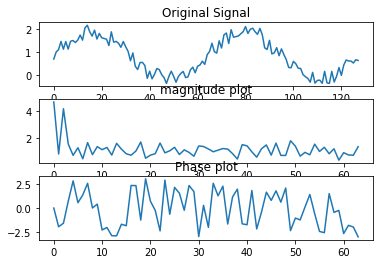

In [12]:
fig = plt.figure()
fig.add_subplot(311)
plt.plot(f)
plt.title('Original Signal')
fig.add_subplot(312)
plt.plot(np.log(np.abs(F[:64]) + 1))
plt.title('magnitude plot')
fig.add_subplot(313)
plt.plot(np.angle(F[:64]))
plt.title('Phase plot')
plt.show()

In [13]:
I_F = inverseFFT_1D(F)

/home/accubits/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


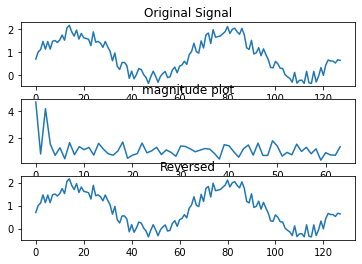

In [14]:
fig = plt.figure()
fig.add_subplot(311)
plt.plot(f)
plt.title('Original Signal')
fig.add_subplot(312)
plt.plot(np.log(np.abs(F[:64]) + 1))
plt.title('magnitude plot')
fig.add_subplot(313)
plt.plot(I_F)
plt.title('Reversed')
plt.show()

(<matplotlib.image.AxesImage at 0x7f838f883ef0>,
 Text(0.5, 1.0, 'Original Image'))

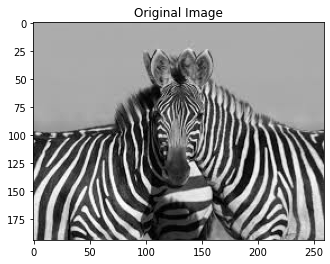

In [17]:
img = cv2.imread('zebra.jpeg', 0)
plt.imshow(img, "gray"), plt.title("Original Image")

In [19]:
img.shape

(194, 259)

In [20]:
resized_img = cv2.resize(img, (256, 256))

In [21]:
resized_img.shape

(256, 256)

In [22]:
fft_img = FFT_2D(resized_img)

TypeError: Image data of dtype complex128 cannot be converted to float

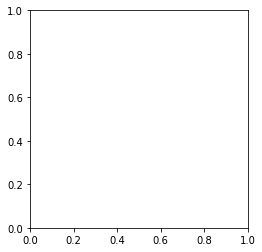

In [23]:
plt.imshow(fft_img, "gray"), plt.title("Transformed Image")